<a href="https://colab.research.google.com/github/kaylil/Audio-Speech-Separation/blob/master/APS360_Audio_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pydub
!pip install sphfile
!pip install wavio

  Created wheel for sphfile: filename=sphfile-1.0.1-cp36-none-any.whl size=3720 sha256=16846f7b07877393f9b7b7c0e4250ef740fc42e2f5478b797ee18b0c711dbc85
  Stored in directory: /root/.cache/pip/wheels/73/a8/71/e339da6bfe707de7c5d1631750b163f36b6ec14efe48f97ec1
Successfully built sphfile


In [0]:
#Imports
import imp
import random
import wavio
import math
import os
import shutil
import datetime
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy import signal
from sphfile import SPHFile
# from chamfer_distance import ChamferDistance

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from pydub import AudioSegment


random.seed(42)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def createDictionarOnlyFirst(directory):
    #This function takes in a path which contains overlaid files and outputs a 
    #dictionary with Person1 as a key and the path of the overlaid file as the value
    dictionary = {}
    
    for filename in os.listdir(directory):
        _, person1, _, dialect2, person2, _ = getOverlayFileInfo(filename)
        path1, path2 = getPathsFromOverlayFile(filename)
        if (person1 not in dictionary):
            dictionary[person1] = []
            dictionary[person1].append(path2)
        else:
            dictionary[person1].append(path2)
    return dictionary
  
def move():
  #This function is for moving all 100,000 files into 10 separate folders, onee at a time.
  os.mkdir("/content/gdrive/My Drive/APS360 Project/Data/Files 9")
  i = 0
  for file in os.listdir("/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/"):
    if i > 9307:
      break
    if i%500 == 0:
      currentDT = datetime.datetime.now()
      print(i, " Time -- ", currentDT.hour, ":", currentDT.minute)
    oldPath = "/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/" + file
    newPath = "/content/gdrive/My Drive/APS360 Project/Data/Files 9"
    shutil.move(oldPath, newPath)
    i+=1

def nameOverlayFile(path1, path2):    
    #This function takes two file paths and outputs the name of their overlay
    dialect1, person1, sentence1 = getFileInfo(path1)
    dialect2, person2, sentence2 = getFileInfo(path2)
    new_file_name = dialect1 + "_" + person1 + "_" + sentence1 + "_" + dialect2 + "_" + person2 + "_" + sentence2
    return new_file_name
    
def getFileInfo(path):
    #This function take a path of a file and returns its details by splitting the file's name
    tokens = path.split("/")
    dialect = tokens[-3]
    person = tokens[-2]
    sentence = tokens[-1].split(".")[0]
    return dialect, person, sentence
  
def getOverlayFileInfo(path):
    #This function takes the path of an overlay file and returns its details by splitting its name
    tokens = path.split("_")
    # return strings in the order of: dialect1, person1, sentence1,dialect2, person2, sentence2
    return tokens[-6], tokens[-5], tokens[-4], tokens[-3], tokens[-2], tokens[-1].split(".")[0]
    
def getPathsFromOverlayFile(oFileName, directory="/content/gdrive/My Drive/APS360 Project/Data/data/lisa/data/timit/raw/TIMIT/TRAIN/"):
    #This function takes in an overlay file's name and returns the paths of the two files it was generated from
    #oFileName can be either the name or path (with "/" at the end) of the overlay file
    dialect1, person1, sentence1, dialect2, person2, sentence2 = getOverlayFileInfo(oFileName)
    path1 = directory + dialect1 + "/" + person1 + "/" + sentence1 + ".WAV"
    path2 = directory + dialect2 + "/" + person2 + "/" + sentence2 + ".WAV"
    return path1, path2
    
def getSpeakers(oFileName):
    #This function takes in an overlay file's name and returns the two people's IDs that were used to generate it
    tokens = oFileName.split("_")
    person1 = tokens[1]
    person2 = tokens[4]
    return person1, person2


def createDictionary(directory):
    #This function takes in a path to overlaid files and returns a dictionary with 
    #people as keys and every overlay file they were part of as their values 
    dictionary = {}
    
    for filename in os.listdir(directory):
        person1, person2 = getSpeakers(filename)
        path1, path2 = getPathsFromOverlayFile(filename)
        if (person1 not in dictionary):
            dictionary[person1] = []
            dictionary[person1].append(path2)
        else:
            dictionary[person1].append(path2)
        if (person2 not in dictionary):
            dictionary[person2] = []
            dictionary[person2].append(path1)
        else:
            dictionary[person2].append(path1)
    return dictionary
    
#Overlay Generation

#check short vs long wav files
#overlay short on long 
#Make File Name
#export it to a folder using file name
#make dictionary
#export dictionary to file

def GenerateOverlay(wav1_Path, wav2_Path):
  #This function takes two paths to wav files and generates and exports an overlay file
  sound1 = AudioSegment.from_file(wav1_Path)
  sound2 = AudioSegment.from_file(wav2_Path)
  if len(sound1) > len(sound2):
    overlaied = sound1.overlay(sound2)
  else: 
    overlaied = sound2.overlay(sound1)
    
  file_handle = overlaied.export("/content/gdrive/My Drive/APS360 Project/Data/Generated Dataset/" + nameOverlayFile(wav1_Path, wav2_Path), format="wav")
  return 

def MainGenerateData(main_path):
  #This function generated all of our data. It was called twice, once for the training set and once for the testing set
  people_paths = []
  for DRx in os.listdir(train_path):                        #loop over everyone in the set
    for person in os.listdir(train_path + DRx):             
      people_paths.append(train_path + DRx + '/' + person)  #append every person's path to a list
  print("All people paths collected...")

  person_to_wavs = dict()                             #dictionary with people's paths as keys, and wav file as values
  for person_path in people_paths:                    #for every person in the data
    person_wavs = []                                  #empty list for this person's WAV files
    for file in os.listdir(person_path):              #for all this peron's files
      if file.endswith("WAV"):                        #find all the WAV files
        person_wavs.append(person_path + '/' + file)  #add all the WAV file paths to a list
    person_to_wavs[person_path] = person_wavs         #{ person's path:[list of their WAV paths] }
  print("Person to WAVs dictionary complete...")
  
  total_files_generated = 0
  for i in range(0, len(people_paths)):                              #for every person
    files_generated_for_this_person = 0
    random_wav_i = random.choice(person_to_wavs[people_paths[i]])    #randomly select one of their wav files
    for j in range(i+1, len(people_paths)):                          #for the remaining people
      random_wav_j = random.choice(person_to_wavs[people_paths[j]])  #randomly select one of their wav files
      GenerateOverlay(random_wav_i, random_wav_j)                    #Overlay one wav on the other
      files_generated_for_this_person += 1
    total_files_generated += files_generated_for_this_person
    print("Completed person ", i+1, " | Files Generated: ", files_generated_for_this_person, " | Total Files: ", total_files_generated)

In [0]:
len(os.listdir("/content/gdrive/My Drive/APS360 Project/Data/Files 1"))

FileNotFoundError: ignored

In [0]:
class DataFile(Dataset):
  def __init__(self, data_folder, transform=None): #dataset = list of paths for overlaid
    self.__xs = [] # list of paths from content to .wav for overlaid
    self.__ys = [] # list of tuples for the ground truths for each overlaid
    for file in os.listdir(data_folder):
        self.__xs.append(data_folder + "/" + file)
        path1, path2 = getPathsFromOverlayFile(file, directory="/content/gdrive/My Drive/APS360 Project/Data/data/lisa/data/timit/raw/TIMIT/TRAIN/")
        self.__ys.append((path1, path2))

  def __getitem__(self, index):
    output1 = self.__xs[index]
    truth = self.__ys[index]
    return output1, truth

  def __len__(self):
    return len(self.__xs)


# data_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files 1")
# train_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)

In [0]:
def matchSize(a, b):
  result = torch.zeros(b.shape)
  result[:a.shape[0],:a.shape[1],:a.shape[2]] = a
  return result

def matchAll(a, b, c,d):
  lens = np.array([a.shape[2], b.shape[2], c.shape[2], d.shape[2]])
  largest_index = lens.argmax()
  all_inputs = [a,b,c,d]
  a = matchSize(a, all_inputs[largest_index])
  b = matchSize(b, all_inputs[largest_index])
  c = matchSize(c, all_inputs[largest_index])
  d = matchSize(d, all_inputs[largest_index])
  return a,b,c,d

In [0]:
#This code loades the overfitting data and prints out the length of the dataset (1 since we only have one file)

data_set1 = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/One File")
train_loader = DataLoader(data_set1, batch_size=1, shuffle=False, num_workers=0)
len(data_set1)

OSError: ignored

In [0]:
class KhaledNet1(nn.Module):
  def __init__(self):
    super(KhaledNet1, self).__init__()
    self.name = "khalednet1"
    self.conv1 = nn.Conv2d(1, 50, 3, padding = 1) # 1 in-channel, 5 out-channels (to learn more), kernel size 3, padding 1 to keep the same size
    self.conv2 = nn.Conv2d(50, 30, 3, padding = 1)
    self.conv3 = nn.Conv2d(30, 10, 3, padding = 1)
    self.conv4 = nn.Conv2d(10, 2, 3, padding = 1) # 5 in-channel, 2 out-channels (one channel per mask?), kernel size 3, padding 1 to keep the same size
  
  def forward(self, x):
    x = F.relu(self.conv1(x))         # using reLU as my nonlinearity
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    output = F.relu(self.conv4(x))
    return output

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()                                                  #I was using Chamfer Loss, but I can't figure out how to import it ~ using MSELoss instead for noww
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)             #using Adam
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:         #Loop over the batch
      batch = 0      #initialize this batch's loss
      for i in range(len(batchData)):                                               #for very file path in the batch
        inputs = signal.stft(SPHFile(batchData[i]).content)[2].astype('int64')          #import and convert the overlay file to an STFT
        truths_stft_1 = signal.stft(SPHFile(truth1[i]).content)[2].astype('int64')  #import and convert the first ground truth file to an STFT
        truths_stft_2 = signal.stft(SPHFile(truth2[i]).content)[2].astype('int64')  #import and convert the second ground truth file to an STFT
        
      inputs = torch.tensor(inputs).unsqueeze(0).unsqueeze(0).float()
      truths_stft_1 = torch.tensor(truths_stft_1).float()
      truths_stft_2 = torch.tensor(truths_stft_2).float()
      
      pred = model(inputs)
      
      pred1 = pred[0,0,:,:]
      pred2 = pred[0,1,:,:]
      
      pred1, pred2, truths_stft_1, truths_stft_2 = matchAll(pred1, pred2, truths_stft_1, truths_stft_2)
      
#       print(truths_stft_1.shape)
#       print(truths_stft_2.shape)
#       print(pred1.shape)
#       print(pred2.shape)
      
      loss1 = criterion(pred1, truths_stft_1)
      loss2 = criterion(pred2, truths_stft_2)
      
      loss3 = criterion(pred1, truths_stft_2)
      loss4 = criterion(pred2, truths_stft_1)
      
      loss_loss = min(loss1+loss2 , loss3+loss4)
      
      optimizer.zero_grad()
      loss_loss.backward()
      optimizer.step()
    print(loss_loss)

In [0]:
from scipy import signal
from sphfile import SPHFile

class KhaledNet2(nn.Module):
  def __init__(self):
    super(KhaledNet2, self).__init__()
    self.name = "khalednet2"
    self.conv1 = nn.Conv2d(2, 50, 3, padding = 1) 
    self.conv2 = nn.Conv2d(50, 30, 3, padding = 1)
    self.conv3 = nn.Conv2d(30, 10, 3, padding = 1)
    self.conv4 = nn.Conv2d(10, 4, 3, padding = 1) 
  
  def forward(self, x):
    x = F.relu(self.conv1(x))         # using reLU as my nonlinearity
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    output = F.relu(self.conv4(x))
    return output
  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()                                                  #I was using Chamfer Loss, but I can't figure out how to import it ~ using MSELoss instead for noww
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)             #using Adam
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:         #Loop over the batch
      batch = 0      #initialize this batch's loss
      for i in range(len(batchData)):                                               #for very file path in the batch
        inputs = signal.stft(SPHFile(batchData[i]).content)[2]
        truths_stft_1 = signal.stft(SPHFile(truth1[i]).content)[2]
        truths_stft_2 = signal.stft(SPHFile(truth2[i]).content)[2]
        
      inputs = torch.tensor([inputs.real, inputs.imag]).unsqueeze(0)
      truths1 = torch.tensor([truths_stft_1.real, truths_stft_1.imag])
      truths2 = torch.tensor([truths_stft_2.real, truths_stft_2.imag])
      
      pred = model(inputs)
      
      pred1 = pred[0,:2,:,:]
      pred2 = pred[0,2:,:,:]
      
      pred1, pred2, truths1, truths2 = matchAll(pred1, pred2, truths1, truths2)
      
#       print(truths_stft_1.shape)
#       print(truths_stft_2.shape)
#       print(pred1.shape)
#       print(pred2.shape)
      
      loss1 = criterion(pred1, truths1)
      loss2 = criterion(pred2, truths2)
      
      loss3 = criterion(pred1, truths2)
      loss4 = criterion(pred2, truths1)
      
      loss_loss = min(loss1+loss2 , loss3+loss4)
      
      optimizer.zero_grad()
      loss_loss.backward()
      optimizer.step()
    print(loss_loss)
    
model = KhaledNet2()

In [0]:
train(model, train_loader, train_loader, num_epochs = 100, learning_rate=1e-4)

In [0]:
from scipy import signal
from sphfile import SPHFile

class KhaledNet3(nn.Module):
  def __init__(self):
    super(KhaledNet3, self).__init__()
    self.name = "khalednet3"
    self.conv1 = nn.Conv2d(2, 50, 3, padding = 1) 
    self.conv2 = nn.Conv2d(50, 30, 3, padding = 1)
    self.conv3 = nn.Conv2d(30, 10, 3, padding = 1)
    self.conv4 = nn.Conv2d(10, 4, 3, padding = 1) 
  
  def forward(self, x):
    x = F.relu(self.conv1(x))         # using reLU as my nonlinearity
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    output = F.relu(self.conv4(x))
    return output
  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()                                                  #I was using Chamfer Loss, but I can't figure out how to import it ~ using MSELoss instead for noww
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)             #using Adam
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:         #Loop over the batch
      batch = 0      #initialize this batch's loss
      for i in range(len(batchData)):                                               #for very file path in the batch
        inputs = signal.stft(SPHFile(batchData[i]).content)[2]
        truths_stft_1 = signal.stft(SPHFile(truth1[i]).content)[2]
        truths_stft_2 = signal.stft(SPHFile(truth2[i]).content)[2]

      inputs = torch.tensor([inputs.real, inputs.imag]).unsqueeze(0)
      truths1 = torch.tensor([truths_stft_1.real, truths_stft_1.imag], dtype=torch.float64)
      truths2 = torch.tensor([truths_stft_2.real, truths_stft_2.imag], dtype=torch.float64)
      
      pred = model(inputs)
      
      pred1 = pred[0,:2,:,:]
      pred2 = pred[0,2:,:,:]
      
      pred1, pred2, truths1, truths2 = matchAll(pred1, pred2, truths1, truths2)
      
#       print(truths_stft_1.shape)
#       print(truths_stft_2.shape)
#       print(pred1.shape)
#       print(pred2.shape)
      
      loss1 = criterion(pred1, truths1)
      loss2 = criterion(pred2, truths2)
      
#       loss3 = criterion(pred1, truths2)
#       loss4 = criterion(pred2, truths1)
      
#       loss_loss = min(loss1+loss2 , loss3+loss4)
      loss_loss = loss1 + loss2
      optimizer.zero_grad()
      loss_loss.backward()
      optimizer.step()
    if epoch % 10 ==0:
      print(loss_loss)
    
model = KhaledNet3()

In [0]:
train(model, train_loader, train_loader, num_epochs = 10000, learning_rate=5e-4)

In [0]:
!mv pytorch-wavenet/ pytorch_wavenet   #renames pytorch-wavenet to pytorch_wavenet cuz dashes/hyphens (the "-" ) are forbidden in python
!ls  pytorch_wavenet    #show me everythig in this folder ~~ this line is unnecessary and was just for me
from pytorch_wavenet import *  #import EVERYTHING

In [0]:
def matchSize(a, b):
  result = torch.zeros(b.shape)
  result[:a.shape[0]] = a
  return result

def matchAll(a, b, c, d, e):
  lens = np.array([a.shape[0], b.shape[0], c.shape[0], d.shape[0], e.shape[0]])
  largest_index = lens.argmax()
  all_inputs = [a,b,c,d,e]
  a = matchSize(a, all_inputs[largest_index])
  b = matchSize(b, all_inputs[largest_index])
  c = matchSize(c, all_inputs[largest_index])
  d = matchSize(d, all_inputs[largest_index])
  e = matchSize(e, all_inputs[largest_index])

  return a,b,c,d, e

class KhaledNet4(nn.Module):
  def __init__(self):
    super(KhaledNet4, self).__init__()
    self.name = "khalednet4"
    self.conv1 = nn.Conv1d(1, 4, 100, padding = 10) 
    self.conv2 = nn.Conv1d(4, 2, 100, padding = 10)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    output = self.conv2(x)
    return output

  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:       
      batch = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content
        truths1 = SPHFile(truth1[i]).content
        truths2 = SPHFile(truth2[i]).content
        
      t_inputs = torch.tensor(inputs.astype("int16"))
      t_truths1 = torch.tensor(truths1.astype("int16"))
      t_truths2 = torch.tensor(truths2.astype("int16"))
      
      pred = model(t_inputs.unsqueeze(0).unsqueeze(0).float())
      
      pred1 = pred[0,0,:]
      pred2 = pred[0,1,:]

      
      pred1, pred2, t_truths1, t_truths2, t_inputs = matchAll(pred1, pred2, t_truths1, t_truths2, t_inputs)

      loss1 = criterion(pred1, t_truths1)
      loss2 = criterion(pred2, t_truths2)
      
      loss3 = criterion(pred1, t_truths2)
      loss4 = criterion(pred2, t_truths1)

#       loss1 = torch.norm(pred1 - t_truths1)
#       loss2 = torch.norm(pred2 - t_truths2)
      
#       loss3 = torch.norm(pred1 - t_truths2)
#       loss4 = torch.norm(pred2 - t_truths1)
      
      min_loss = min(loss1+loss2 , loss3+loss4)
      recon_loss = criterion(t_inputs, (pred1 + pred2))
      
      total_loss = min_loss + recon_loss
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    if epoch % 10 ==0:
      print(total_loss)


In [0]:
class KhaledNetFC(nn.Module):
  def __init__(self):
    super(KhaledNetFC, self).__init__()
    self.name = "KhaledNetFC"
    self.fc1 = nn.Linear(100, 200) 
  
  def forward(self, x):
    output = self.fc1(x)
    return output
  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:       
      batch = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content[:100]
        truths1 = SPHFile(truth1[i]).content[:100]
        truths2 = SPHFile(truth2[i]).content[:100]
      
      t_inputs = torch.tensor(inputs.astype("int16"))
      t_truths1 = torch.tensor(truths1.astype("int16"))
      t_truths2 = torch.tensor(truths2.astype("int16"))
      
      pred = model(t_inputs.float())
      
      pred1 = pred[:100]
      pred2 = pred[100:]

      
#       pred1, pred2, t_truths1, t_truths2, t_inputs = matchAll(pred1, pred2, t_truths1, t_truths2, t_inputs)

      loss1 = criterion(pred1.float(), t_truths1.float())
      loss2 = criterion(pred2.float(), t_truths2.float())
      
      loss3 = criterion(pred1.float(), t_truths2.float())
      loss4 = criterion(pred2.float(), t_truths1.float())

#       loss1 = torch.norm(pred1 - t_truths1)
#       loss2 = torch.norm(pred2 - t_truths2)
      
#       loss3 = torch.norm(pred1 - t_truths2)
#       loss4 = torch.norm(pred2 - t_truths1)
      
      min_loss = min(loss1+loss3 , loss2+loss4)
      recon_loss = criterion(t_inputs.float(), (pred1 + pred2).float())
      total_loss = min_loss + recon_loss
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    if epoch % 100 ==0:
#       print("MIN of both: ", min_loss, "reconstruction: ", recon_loss)
      print(loss1+loss2, loss3 + loss4)
#       print(total_loss)

In [0]:
train(m, train_loader, train_loader, num_epochs=10000, learning_rate=1e-5)

In [0]:
input_array = SPHFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/DR5_MPMB0_SX151_DR4_MJPM1_SX311").content

t_input = torch.tensor(input_array.astype("int16"))
t_CB = t_input.unsqueeze(0).unsqueeze(0).float()
out = m(t_CB)
sound1 = out[0,0,:]
sound2 = out[0,1,:]

sound1numpy = sound1.detach().numpy()
sound2numpy = sound2.detach().numpy()

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/test9.wav", sound1numpy.astype("int16"), 16000)
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/test10.wav", sound2numpy.astype("int16"), 16000)

In [0]:
#To import an SPH file
sph = SPHFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/DR5_MPMB0_SX151_DR4_MJPM1_SX311")

#To get the sph file's content (a numpy array)
sph_numpy = sph.content

#To calculate a numpy array's STFT
f, t, Zxx = signal.stft(sph_numpy)
#where f is Array of sample frequencies.
#where t is Array of segment times.
#where Zxx is STFT of x.

#To get the numpy array from an STFT
t, x = signal.istft(Zxx)
#where t is Array of output data times.
#where x is iSTFT of Zxx.

In [0]:
#This is where I tried the concept of using an RNN that takes in a fixed-size array of 46000 numbers (i wanted 48000, which was 3 seconds
#(but the file i was working with was a little bit shorted so i went with 46000 just for testing) using a hidden size of 100, then connects
#to a fully connected layer which takes the last hidden state and uses it to output 46000 numbers. The output of the FC is a mask that i 
#multiplied with the original overlay file to generate one of the speakers.

#This worked FLAWLESSLY. I had a working proof of concept. I went to swim for an hour and came back to contine in the next big comment

class KhaledNetRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 46000)
  
  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:       
      batch = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content[:46000]
        truths1 = SPHFile(truth1[i]).content[:46000]
        truths2 = SPHFile(truth2[i]).content[:46000]
      
      t_inputs = torch.tensor(inputs.astype("int16"))
      t_truths1 = torch.tensor(truths1.astype("int16"))
      t_truths2 = torch.tensor(truths2.astype("int16"))
      
      pred = model(t_inputs.float().unsqueeze(0).unsqueeze(0))

      loss1 = criterion(pred.float() * t_inputs.float(), t_truths1.float())
      
#       min_loss = min(loss1+loss3 , loss2+loss4)
#       recon_loss = criterion(t_inputs.float(), (pred1 + pred2).float())
#       total_loss = min_loss + recon_loss
      
      optimizer.zero_grad()
      loss1.backward()
      optimizer.step()
    if epoch % 10 ==0:
      print(loss1)


In [0]:
model = KhaledNetRNN(46000,100)

In [0]:
train(model, overfit_loader, overfit_loader, num_epochs=100, learning_rate=5e-3)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([46000])) that is different to the input size (torch.Size([1, 46000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(597388.5000, grad_fn=<MseLossBackward>)
tensor(100112.4688, grad_fn=<MseLossBackward>)
tensor(49069.6719, grad_fn=<MseLossBackward>)
tensor(27902.4609, grad_fn=<MseLossBackward>)
tensor(18649.9609, grad_fn=<MseLossBackward>)
tensor(13870.1699, grad_fn=<MseLossBackward>)
tensor(11171.2051, grad_fn=<MseLossBackward>)
tensor(9435.5420, grad_fn=<MseLossBackward>)
tensor(8199.4688, grad_fn=<MseLossBackward>)
tensor(7267.2676, grad_fn=<MseLossBackward>)


In [0]:
for x in train_loader:
  inputs = torch.tensor(SPHFile(x[0][0]).content[:46000].astype("int16")).float().unsqueeze(0).unsqueeze(0) #get the overlay file

out = model(inputs)  #run it through the model

out.shape #debug

torch.Size([1, 46000])

In [0]:
export_this = inputs.squeeze() * out.squeeze()  #multiply the mask that came out of the model by the overlay file
export_this = export_this.detach().numpy()   #ugh idk why i need to do this

In [0]:
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/newtest100.wav", export_this.astype("int16"), 16000) #omgomgomgitsoundsbeautiful

In [0]:
np.random.randint(-30000,30000, 46000)

array([ 25177, -12586,  -2245, ..., -12400,  27598, -26684])

In [0]:
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/noise.wav", np.random.randint(-30000,30000, 46000).astype("int16"), 16000) #omgomgomgitsoundsbeautiful

In [0]:
out #just making sure the numbers make sense (lol idk why i think these make sense but at least theyre not all 1 or 0, right?)

tensor([[-0.9452,  3.4934, -1.3946,  ..., -0.0664,  0.1471, -0.2035]],
       grad_fn=<AddmmBackward>)

In [0]:
#okayyyy so i finished swimming time to DO THIS

#changed the RNN's input size to 32000 (2 seconds worth of audio) jut to make sure I didnt fluke the first one, and to make calculations a little quicker.
#again, added a fully connected layer that takes in the RNN's hidden size of 100, but then changed the output to 32000 TIMES 2. so a mask of size 32000
#for each of our speakers

#again, it worked perfectly. over fit, no noise, super fast (like 2000 epochs/5mins of training to reach a loss of ~5000)

class KhaledNetRNN2(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN2, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN2"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 16000*2)
  
  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:       
      batch = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content[:16000]
        truths1 = SPHFile(truth1[i]).content[:16000]
        truths2 = SPHFile(truth2[i]).content[:16000]
      
      t_inputs = torch.tensor(inputs.astype("int16"))
      t_truths1 = torch.tensor(truths1.astype("int16"))
      t_truths2 = torch.tensor(truths2.astype("int16"))
      
      pred = model(t_inputs.float().unsqueeze(0).unsqueeze(0)).squeeze(0)

      loss1 = criterion(pred[:16000].float() * t_inputs.float(), t_truths1.float())
      loss2 = criterion(pred[16000:].float() * t_inputs.float(), t_truths2.float())

      total_loss = loss1 + loss2
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    if epoch % 10 ==0:
      print(total_loss)


In [0]:
model2 = KhaledNetRNN2(16000,100) #define model

In [0]:
train(model2, overfit_loader, train_loader, num_epochs=50, learning_rate=7e-3) #train

tensor(1106725.8750, grad_fn=<AddBackward0>)
tensor(167442.8438, grad_fn=<AddBackward0>)
tensor(62490.7383, grad_fn=<AddBackward0>)
tensor(27451.7344, grad_fn=<AddBackward0>)
tensor(13828.6094, grad_fn=<AddBackward0>)


In [0]:
for x in overfit_loader:
  inputs = torch.tensor(SPHFile(x[0][0]).content[:16000].astype("int16")).float().unsqueeze(0).unsqueeze(0)  #get the file
  break

out = model2(inputs) #get the prediction

export_this1 = inputs.squeeze() * out.squeeze()[:16000]  #multiply the first half of the mask by the overlay file
export_this2 = inputs.squeeze() * out.squeeze()[16000:]  #multiply the second half of the mask by the overlay file


export_this1 = export_this1.detach().numpy() #ugh
export_this2 = export_this2.detach().numpy() #not this again

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/Presentation_output1.wav", export_this1.astype("int16"), 16000)  #output the first dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/Presentation_output2.wav", export_this2.astype("int16"), 16000)  #output the second dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/Presentation_overlay.wav", inputs.detach().numpy().astype("int16"), 16000) #output the original file to make sure 
                                                                                                                        #i wasnt doing anything wrong

In [0]:
#thanks for coming to my tedtalk

In [0]:
t = torch.tensor([1,1,1,1,1,1])

In [0]:
len(t)

6

In [0]:
math.ceil(len(t)/16000)

1

In [0]:
import math


In [0]:
def chunkate(tensor, number_of_chunks):
  padded_tensor = torch.zeros(number_of_chunks * 16000)
  padded_tensor[:len(tensor)] = tensor
  chunks = []
  for chunk in range(number_of_chunks):
    chunks.append(padded_tensor[chunk * 16000: (chunk+1) *16000])
  return chunks

class KhaledNetRNN3(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN3, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN3"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, input_size*2)
  
  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:  
      batch_loss = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content
        truths1 = SPHFile(truth1[i]).content
        truths2 = SPHFile(truth2[i]).content

        t_inputs = torch.tensor(inputs.astype("int16"))
        t_truths1 = torch.tensor(truths1.astype("int16"))
        t_truths2 = torch.tensor(truths2.astype("int16"))
        
        number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)
        
        input_chunks = chunkate(t_inputs, number_of_chunks)
        truth1_chunks = chunkate(t_truths1, number_of_chunks)
        truth2_chunks = chunkate(t_truths2, number_of_chunks)
        
        for j in range(number_of_chunks):
          pred = model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)
          loss1 = criterion(pred[:16000].float() * input_chunks[j].float(), truth1_chunks[j].float())
          loss2 = criterion(pred[16000:].float() * input_chunks[j].float(), truth2_chunks[j].float())
          batch_loss += loss1 + loss2
      print(batch_loss)

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
    if epoch % 10 ==0:
      print(batch_loss)

In [0]:
model = KhaledNetRNN3(16000,1000)

In [0]:
train(model, overfit_loader, overfit_loader, num_epochs=500, learning_rate=5e-3) #train

In [0]:
i = 0
for x in train_loader:
  inputs = torch.tensor(SPHFile(x[0][0]).content.astype("int16"))  #get the file
  i+=1
  if i == 1:
    break

number_of_chunks = math.ceil(len(inputs)/16000)
input_chunks = chunkate(inputs, number_of_chunks)

speaker1 = torch.tensor([])
speaker2 = torch.tensor([])

for j in range(number_of_chunks):
  masks = modelA(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)  
  out_chunk1 = input_chunks[j].squeeze() * masks.squeeze()[:16000]  #multiply the first half of the mask by the overlay file
  out_chunk2 = input_chunks[j].squeeze() * masks.squeeze()[16000:]  #multiply the second half of the mask by the overlay file
  speaker1 = torch.cat((speaker1, out_chunk1.cpu()))
  speaker2 = torch.cat((speaker2, out_chunk2.cpu()))


export_this1 = speaker1.detach().numpy() #ugh
export_this2 = speaker2.detach().numpy() #not this again

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/test110.wav", export_this1.astype("int16"), 16000)  #output the first dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/test111.wav", export_this2.astype("int16"), 16000)  #output the second dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/test112.wav", inputs.detach().numpy().astype("int16"), 16000) #output the original file to make sure 
                                                                                                                        #i wasnt doing anything wrong

In [0]:
#This part is my gpu test

def chunkate(tensor, number_of_chunks):
  padded_tensor = torch.zeros(number_of_chunks * 16000).cuda()
  padded_tensor[:len(tensor)] = tensor
  chunks = []
  for chunk in range(number_of_chunks):
    chunks.append(padded_tensor[chunk * 16000: (chunk+1) *16000].cuda())
  return chunks

class KhaledNetRNN33(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN33, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN3"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True).cuda()
    self.fc = nn.Linear(hidden_size, input_size*2).cuda()
  
  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
    x.cuda()
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

  
def get_accuracy(model, data_loader):
  losses = []
  criterion = nn.MSELoss()
  for batchData, (truth1, truth2) in data_loader:  
    batch_loss = 0    
    for i in range(len(batchData)):                
      inputs = SPHFile(batchData[i]).content
      truths1 = SPHFile(truth1[i]).content
      truths2 = SPHFile(truth2[i]).content

      t_inputs = torch.tensor(inputs.astype("int16")).cuda()
      t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
      t_truths2 = torch.tensor(truths2.astype("int16")).cuda()

      number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)

      input_chunks = chunkate(t_inputs, number_of_chunks)
      truth1_chunks = chunkate(t_truths1, number_of_chunks)
      truth2_chunks = chunkate(t_truths2, number_of_chunks)

      for j in range(number_of_chunks):
        pred = model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)
        loss1 = criterion(pred[:16000].float() * input_chunks[j].float(), truth1_chunks[j].float())
        loss2 = criterion(pred[16000:].float() * input_chunks[j].float(), truth2_chunks[j].float())
        batch_loss += loss1 + loss2
    losses.append(batch_loss.item())
  average_loss = np.array(losses).mean()
  return average_loss

  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  loss = []
  loss_counter = 0
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:  
      batch_loss = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content
        truths1 = SPHFile(truth1[i]).content
        truths2 = SPHFile(truth2[i]).content

        t_inputs = torch.tensor(inputs.astype("int16")).cuda()
        t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
        t_truths2 = torch.tensor(truths2.astype("int16")).cuda()
        
        number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)
        
        input_chunks = chunkate(t_inputs, number_of_chunks)
        truth1_chunks = chunkate(t_truths1, number_of_chunks)
        truth2_chunks = chunkate(t_truths2, number_of_chunks)
        
        for j in range(number_of_chunks):
          pred = model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)
          loss1 = criterion(pred[:16000].float() * input_chunks[j].float(), truth1_chunks[j].float())
          loss2 = criterion(pred[16000:].float() * input_chunks[j].float(), truth2_chunks[j].float())
          batch_loss += loss1 + loss2
          
      
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      loss.append(batch_loss)
      loss_counter += 1
      
#       if loss_counter % 10 == 0:
#         print("Batch ", loss_counter, ": ", batch_loss.item())
      if loss_counter % 500 == 0:
        plt.plot(loss)
        plt.show()
      if loss_counter % 1000 == 0:
        model_name = "RNN400" + str(loss_counter)
        torch.save(model.state_dict, "/content/gdrive/My Drive/APS360 Project/Data/Model Checkpoints/"+model_name)
    if epoch % 10 ==0:
      print("Epoch Loss: ", batch_loss)

In [0]:
overfit_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/One File/")
overfit_loader = DataLoader(overfit_set, batch_size=1, shuffle=True, num_workers=0)
print(len(overfit_set))

train_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/Train/")
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
print(len(train_set))

val_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Files Overfit/Validation/")
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)
print(len(val_set))

1
20
20


In [0]:
model = KhaledNetRNN33(16000,100)

In [0]:
t1 = torch.randn(1,16000).cuda()
t2 = torch.randn(1,16000).cuda()
t = torch.stack([t1,t2])
model(t)

tensor([[-0.4365, -0.4413, -0.2952,  ...,  0.1278, -0.4277,  0.1733],
        [-0.1458,  0.6846,  0.1563,  ..., -0.2140,  0.2658,  0.2985]],
       device='cuda:0', grad_fn=<AddmmBackward>)

Epoch Loss:  tensor(1637805.2500, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1487712., device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1279081.8750, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1206891.6250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1194151.6250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1215448.6250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1210088.1250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1161341.3750, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1106008.2500, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1079231.5000, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1021484.2500, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(1028594.8750, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(985421.6250, device='cuda:0', grad_fn=<AddBackward0>)


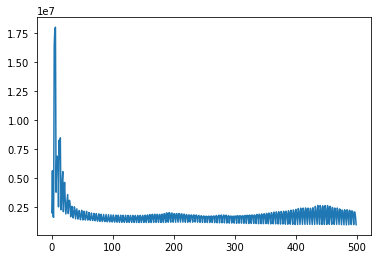

Epoch Loss:  tensor(991427.8750, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(978408.6250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(942203.1875, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(932931.4375, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(944169.1250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(881654.8750, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(875671.2500, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(898055.8125, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(862312., device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(859057.3125, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(900063.4375, device='cuda:0', grad_fn=<AddBackward0>)
Epoch Loss:  tensor(862082.7500, device='cuda:0', grad_fn=<AddBackward0>)


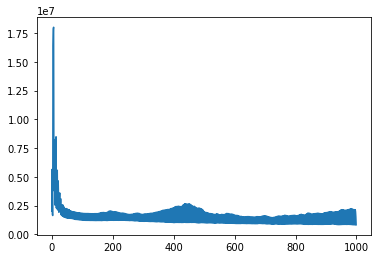

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type KhaledNetRNN33. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


PicklingError: ignored

In [0]:
train(model, train_loader, train_loader, num_epochs=500, learning_rate=1e-3) #train

In [0]:
one = torch.tensor([[1.0,1.0,1.0],[2.0,2.0,2.0]])
t1 = torch.tensor([0.1,0.1,0.1])
t2 = torch.tensor([3.0,2.0,2.0])

t = torch.stack((t1,t2))
t*one

tensor([[0.1000, 0.1000, 0.1000],
        [6.0000, 4.0000, 4.0000]])

tensor([1, 1, 1])

In [0]:
# Added get_loss function and considered validation loader when calculating loss and graphing the training curve

def chunkate(tensor, number_of_chunks):
  padded_tensor = torch.zeros(number_of_chunks * 16000).cuda()
  padded_tensor[:len(tensor)] = tensor
  chunks = []
  for chunk in range(number_of_chunks):
    chunks.append(padded_tensor[chunk * 16000: (chunk+1) *16000].cuda())
  return chunks

class BaselineRNN33(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN33, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN3"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True).cuda()
    self.fc = nn.Linear(hidden_size, input_size*2).cuda()
  
  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
    x.cuda()
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

  
def get_loss(model, data_loader):
  losses = []
  criterion = nn.MSELoss()
  for batchData, (truth1, truth2) in data_loader:  
    batch_loss = 0    
    for i in range(len(batchData)):                
      inputs = SPHFile(batchData[i]).content
      truths1 = SPHFile(truth1[i]).content
      truths2 = SPHFile(truth2[i]).content

      t_inputs = torch.tensor(inputs.astype("int16")).cuda()
      t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
      t_truths2 = torch.tensor(truths2.astype("int16")).cuda()

      number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)

      input_chunks = chunkate(t_inputs, number_of_chunks)
      truth1_chunks = chunkate(t_truths1, number_of_chunks)
      truth2_chunks = chunkate(t_truths2, number_of_chunks)

      for j in range(number_of_chunks):
        pred = model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)
        loss1 = criterion(pred[:16000].float() * input_chunks[j].float(), truth1_chunks[j].float())
        loss2 = criterion(pred[16000:].float() * input_chunks[j].float(), truth2_chunks[j].float())
        batch_loss += loss1 + loss2
    losses.append(batch_loss.item())
  average_loss = np.array(losses).mean()
  return average_loss

  
def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4): 
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  loss = []
  val_loss = [] # an array of validation losses
  loss_counter = 0
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:  
      batch_loss = 0    
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content
        truths1 = SPHFile(truth1[i]).content
        truths2 = SPHFile(truth2[i]).content

        t_inputs = torch.tensor(inputs.astype("int16")).cuda()
        t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
        t_truths2 = torch.tensor(truths2.astype("int16")).cuda()
        
        number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)
        
        input_chunks = chunkate(t_inputs, number_of_chunks)
        truth1_chunks = chunkate(t_truths1, number_of_chunks)
        truth2_chunks = chunkate(t_truths2, number_of_chunks)
        
        for j in range(number_of_chunks):
          pred = model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)
          loss1 = criterion(pred[:16000].float() * input_chunks[j].float(), truth1_chunks[j].float())
          loss2 = criterion(pred[16000:].float() * input_chunks[j].float(), truth2_chunks[j].float())
          batch_loss += loss1 + loss2
          
      
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      loss.append(batch_loss)
      
      # Calculating validation loss using "get_loss" function
      val_loss1 = get_loss(model, valid_loader)
      val_loss.append(val_loss1)
      
      loss_counter += 1
      
#       if loss_counter % 10 == 0:
#         print("Batch ", loss_counter, ": ", batch_loss.item())
      if loss_counter % 500 == 0:
        plt.title("Training Curve")
        plt.plot(loss, label="Train")
        plt.plot(val_loss, label="Validation")
        plt.xlabel("Counter")
        plt.ylabel("Loss")
        plt.show()
      if loss_counter % 1000 == 0:
        model_name = "RNN400" + str(loss_counter)
        torch.save(model.state_dict, "/content/gdrive/My Drive/APS360 Project/Data/Model Checkpoints/"+model_name)
    if epoch % 10 == 0:
      print("Train loss:", batch_loss, "Validation loss:", val_loss1)

In [0]:
modelA = BaselineRNN33(16000,1000)
# train(modelA, train_loader, val_loader, num_epochs=500, learning_rate=1e-3) #train

In [0]:
#proper batching 
def get_loss(model, data_loader):
  losses = []
  criterion = nn.MSELoss()
  for batchData, (truth1, truth2) in train_loader:  
    batch_loss = 0 

    batch_inputs = []
    batch_truths1 = []
    batch_truths2 = []

    for i in range(len(batchData)):                
      inputs = SPHFile(batchData[i]).content
      truths1 = SPHFile(truth1[i]).content
      truths2 = SPHFile(truth2[i]).content

      t_inputs = torch.tensor(inputs.astype("int16")).cuda()
      t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
      t_truths2 = torch.tensor(truths2.astype("int16")).cuda()

      number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)

      input_chunks = chunkate(t_inputs, number_of_chunks)
      truth1_chunks = chunkate(t_truths1, number_of_chunks)
      truth2_chunks = chunkate(t_truths2, number_of_chunks)

      for j in range(number_of_chunks):
        batch_inputs.append(input_chunks[j].float().cuda())
        batch_truths1.append(truth1_chunks[j].float().cuda())
        batch_truths2.append(truth2_chunks[j].float().cuda())

    batch_inputs = torch.stack(batch_inputs).cuda()
    batch_truths1 = torch.stack(batch_truths1).cuda()
    batch_truths2 = torch.stack(batch_truths2).cuda()

    pred = model(batch_inputs.unsqueeze(1))

    loss1 = criterion(pred[:, :16000].float() * batch_inputs, batch_truths1)
    loss2 = criterion(pred[:, 16000:].float() * batch_inputs, batch_truths2)

    batch_loss = (loss1 + loss2)/len(pred)
    losses.append(batch_loss.item())
    break
  average_loss = np.array(losses).mean()
  return average_loss


def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4): 
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
  loss = []
  val_loss = [] # an array of validation losses
  loss_counter = 0
  for epoch in range(num_epochs): 
    for batchData, (truth1, truth2) in train_loader:  
      batch_loss = 0 
      
      batch_inputs = []
      batch_truths1 = []
      batch_truths2 = []
      
      for i in range(len(batchData)):                
        inputs = SPHFile(batchData[i]).content
        truths1 = SPHFile(truth1[i]).content
        truths2 = SPHFile(truth2[i]).content

        t_inputs = torch.tensor(inputs.astype("int16")).cuda()
        t_truths1 = torch.tensor(truths1.astype("int16")).cuda()
        t_truths2 = torch.tensor(truths2.astype("int16")).cuda()
        
        number_of_chunks = math.ceil(max(len(t_inputs), len(t_truths1), len(t_truths2))/16000)
        
        input_chunks = chunkate(t_inputs, number_of_chunks)
        truth1_chunks = chunkate(t_truths1, number_of_chunks)
        truth2_chunks = chunkate(t_truths2, number_of_chunks)
        
#         print(len(inputs))
#         print(number_of_chunks)
        
        for j in range(number_of_chunks):
          batch_inputs.append(input_chunks[j].float().cuda())
          batch_truths1.append(truth1_chunks[j].float().cuda())
          batch_truths2.append(truth2_chunks[j].float().cuda())
      
      batch_inputs = torch.stack(batch_inputs).cuda()
      batch_truths1 = torch.stack(batch_truths1).cuda()
      batch_truths2 = torch.stack(batch_truths2).cuda()
      
      pred = model(batch_inputs.unsqueeze(1))
      
#       print("Done prediction")
      loss1 = criterion(pred[:, :16000].float() * batch_inputs, batch_truths1)
      loss2 = criterion(pred[:, 16000:].float() * batch_inputs, batch_truths2)
      
      batch_loss = (loss1 + loss2)/len(pred)
#       print("Got loss")
      
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      loss.append(batch_loss)
      
#       print("Done backward pass")
      
      # Calculating validation loss using "get_loss" function
      val_loss1 = get_loss(model, valid_loader)
#       print("Got val loss")
      val_loss.append(val_loss1)
      print("Train loss:", batch_loss.item(), "Validation loss:", val_loss1)
      loss_counter += 1
      
#       if loss_counter % 10 == 0:
#         print("Batch ", loss_counter, ": ", batch_loss.item())
      if loss_counter % 10 == 0:
        plt.title("Training Curve")
        plt.plot(loss, label="Train")
        plt.plot(val_loss, label="Validation")
        plt.xlabel("Counter")
        plt.ylabel("Loss")
        plt.show()
      if loss_counter % 1000 == 0:
        model_name = "RNN400" + str(loss_counter)
        torch.save(model.state_dict, "/content/gdrive/My Drive/APS360 Project/Data/Model Checkpoints/"+model_name)
    if epoch % 1 == 0:
      print("Epoch loss:", batch_loss.item(), "Validation loss:", val_loss1)

In [0]:
train_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Train/")
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
print(len(train_set))

val_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Val/")
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)
print(len(val_set))

test_set = DataFile("/content/gdrive/My Drive/APS360 Project/Data/Test/")
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0)
print(len(test_set))

5975
3984
1000


In [0]:
baseline = BaselineRNN33(16000,100)
train(baseline, train_loader, val_loader, num_epochs=10, learning_rate=1e-3) #train

In [0]:
actual = BaselineRNN33(16000,1000)
train(actual, train_loader, val_loader, num_epochs=10, learning_rate=1e-3) #train

In [0]:
i = 0
for x in train_loader:
  inputs = torch.tensor(SPHFile(x[0][0]).content.astype("int16"))  #get the file
  i+=1
  if i == 1:
    break

number_of_chunks = math.ceil(len(inputs)/16000)
input_chunks = chunkate(inputs, number_of_chunks)

speaker1 = torch.tensor([])
speaker2 = torch.tensor([])

for j in range(number_of_chunks):
  masks = baseline(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)  
  out_chunk1 = input_chunks[j].squeeze() * masks.squeeze()[:16000]  #multiply the first half of the mask by the overlay file
  out_chunk2 = input_chunks[j].squeeze() * masks.squeeze()[16000:]  #multiply the second half of the mask by the overlay file
  speaker1 = torch.cat((speaker1, out_chunk1.cpu()))
  speaker2 = torch.cat((speaker2, out_chunk2.cpu()))


export_this1 = speaker1.detach().numpy() #ugh
export_this2 = speaker2.detach().numpy() #not this again

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testBaseline1.wav", export_this1.astype("int16"), 16000)  #output the first dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testBaseline2.wav", export_this2.astype("int16"), 16000)  #output the second dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testBaseline3.wav", inputs.detach().numpy().astype("int16"), 16000) #output the original file to make sure 
                                                                                                                        #i wasnt doing anything wrong
  
for j in range(number_of_chunks):
  masks = actual(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)  
  out_chunk1 = input_chunks[j].squeeze() * masks.squeeze()[:16000]  #multiply the first half of the mask by the overlay file
  out_chunk2 = input_chunks[j].squeeze() * masks.squeeze()[16000:]  #multiply the second half of the mask by the overlay file
  speaker1 = torch.cat((speaker1, out_chunk1.cpu()))
  speaker2 = torch.cat((speaker2, out_chunk2.cpu()))


export_this1 = speaker1.detach().numpy() #ugh
export_this2 = speaker2.detach().numpy() #not this again

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testActual1.wav", export_this1.astype("int16"), 16000)  #output the first dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testActual2.wav", export_this2.astype("int16"), 16000)  #output the second dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/testActual3.wav", inputs.detach().numpy().astype("int16"), 16000) #output the original file to make sure 
                                                                                                                        #i wasnt doing anything wrong

In [0]:
class KhaledNetRNN4(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetRNN4, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetRNN4"
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=5).cuda()
    self.fc = nn.Linear(hidden_size, input_size*2).cuda()
  
  def forward(self, x):
    h0 = torch.zeros(5, x.size(0), self.hidden_size).cuda()
    x.cuda()
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

In [0]:
deep_model = KhaledNetRNN4(16000,10)

In [0]:
train(deep_model, train_loader, val_loader, num_epochs=1, learning_rate=1e-4) #train

In [0]:
class KhaledNetGRU(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(KhaledNetGRU, self).__init__()
    self.hidden_size = hidden_size
    self.name = "KhaledNetGRU"
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers = 2).cuda()
    self.fc = nn.Linear(hidden_size, input_size*2).cuda()
  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
    x.cuda()
    output, _ = self.rnn(x, h0)
    output = self.fc(output[:, -1, :])
    return output

In [0]:
GRU_model = KhaledNetGRU(16000,100)

In [0]:
train(GRU_model, train_loader, val_loader, num_epochs=1000, learning_rate=1e-2) #train

NameError: ignored

In [0]:
i = 0
for x in train_loader:
  inputs = torch.tensor(SPHFile(x[0][0]).content.astype("int16"))  #get the file
  i+=1
  if i == 1:
    break

number_of_chunks = math.ceil(len(inputs)/16000)
input_chunks = chunkate(inputs, number_of_chunks)

speaker1 = torch.tensor([])
speaker2 = torch.tensor([])

for j in range(number_of_chunks):
  masks = GRU_model(input_chunks[j].float().unsqueeze(0).unsqueeze(0)).squeeze(0)  
  out_chunk1 = input_chunks[j].squeeze() * masks.squeeze()[:16000]  #multiply the first half of the mask by the overlay file
  out_chunk2 = input_chunks[j].squeeze() * masks.squeeze()[16000:]  #multiply the second half of the mask by the overlay file
  speaker1 = torch.cat((speaker1, out_chunk1.cpu()))
  speaker2 = torch.cat((speaker2, out_chunk2.cpu()))


export_this1 = speaker1.detach().numpy() #ugh
export_this2 = speaker2.detach().numpy() #not this again

wavio.write("/content/gdrive/My Drive/APS360 Project/Data/GRU1.wav", export_this1.astype("int16"), 16000)  #output the first dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/GRU2.wav", export_this2.astype("int16"), 16000)  #output the second dude
wavio.write("/content/gdrive/My Drive/APS360 Project/Data/GRU3.wav", inputs.detach().numpy().astype("int16"), 16000) #output the original file to make sure 
                                                                                                                        #i wasnt doing anything wrong